### Introduction
In this section we will see how to create custom datasets  
like torchvision dataset gives us, from our own images
We will use Cats and Dogs Dataset for the same

In [1]:
import os
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset
from skimage import io
from PIL import Image

In [2]:
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader, random_split

In [3]:
#hyperparams
in_channel = 3
num_classes = 2
learning_rate = 1e-3
image_size = 224
batch_size = 32
num_epochs = 1

Start with creating a class that will help us load the data

In [4]:
class CatsAndDogsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        #return length of the passed dataset
        return len(self.annotations)
    
    def __getitem__(self, index):
        #return an image along with its target
        img_path = os.path.join(self.root_dir,
                                self.annotations.iloc[index,0])
        im = io.imread(img_path)
        #plt.imshow(im)
        #im = im.astype(float)/255.0
        image = Image.fromarray(im)
        y_label = torch.tensor(int(self.annotations.iloc[index,1]))
        
        if self.transform:
            image = self.transform(image)
        
        return (image, y_label)

### Loading the Dataset

In [5]:
transform = transforms.Compose([transforms.Resize((image_size,image_size)),
                                transforms.ToTensor()])
dataset = CatsAndDogsDataset(csv_file = 'D:/Datasets/dogs-vs-cats/dogs-vs-cats.csv',
                            root_dir = 'D:/Datasets/dogs-vs-cats/train/',
                            transform = transform)

In [6]:
train_set, test_set = random_split(dataset, [20000, 5000])

train_loader = DataLoader(dataset = train_set, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_set, batch_size = batch_size, shuffle = True)

#### Visualizing the Dataset

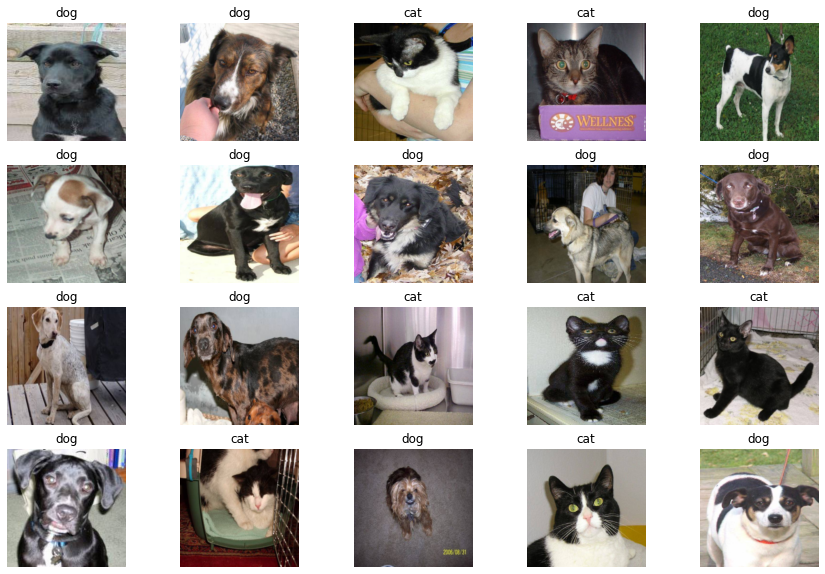

In [7]:
import matplotlib.pyplot as plt
import random 
#image = dataset.__getitem__(0)
#print(len(dataset))
plt.figure(figsize = (15,10))

for i in range(20):
    rand_idx = random.randint(0,25000)
    image, label = dataset.__getitem__(rand_idx)
    tx_label = 'dog' if label == 1 else 'cat'
    plt.subplot(4,5,i+1)
    plt.axis('off')
    plt.title(tx_label)
    plt.imshow(image.permute(1,2,0))

### Creating and Init and Model

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using '+str(device)+' device')

using cuda device


In [9]:
#we will use googlenet inception model
model = torchvision.models.googlenet(pretrained=True)
model.to(device);

#freezing the original weights as otherwise they will get trained
for param in model.parameters():
    param.requires_grad = False
    
#now changing the last fc layer
model.fc = nn.Sequential(nn.Linear(1024, 256),
                         nn.ReLU(),
                         nn.Dropout(0.30),
                         nn.Linear(256, 32),
                         nn.ReLU(),
                         nn.Dropout(0.30),
                         nn.Linear(32, 2))

In [10]:
#print(model)

In [11]:
#Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),
                       lr = learning_rate)

#### Visualizing the Model in Netron

In [13]:
import netron

onnx_path = "./models/googlenet.onnx"
dummy_input = torch.randn(1, in_channel, image_size, image_size).to(device) 
torch.onnx.export(model, dummy_input, onnx_path)

#netron.start(onnx_path)

### Training and Evaluating the Model

In [14]:
%%time
# Train Loop
for epoch in range(num_epochs):
    losses = []
    
    for batch_idx, (data, targets) in enumerate(train_loader):
        #get data to cuda
        data = data.to(device)
        targets = targets.to(device)
        
        #forward
        scores = model(data)
        loss = criterion(scores, targets)
        losses.append(loss)
        
        #backward
        optimizer.zero_grad()
        loss.backward()
        
        #grad descent
        optimizer.step()
    
    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses)}")

Cost at epoch 0 is 0.14092007279396057
Wall time: 3min 4s


In [17]:
def check_accuracy(loader,model):
    num_corr = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_corr += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f"Got {num_corr} / {num_samples} with accuracy {100*float(num_corr)/float(num_samples):.2f }")
    
    
    model.train()

In [18]:
print("Training Accuracy")
check_accuracy(train_loader, model)

print("Testing Accuracy")
check_accuracy(test_loader, model)

Training Accuracy


ValueError: Invalid format specifier